# Explain Spam Detection Using LIME and SHAP

## Agenda
1. Representing Text as numerical data
2. Reading the SMS data
3. Vectorizing the SMS data
4. ***Local Post-Hoc Interpretation***: Explain the Random Forest model using **LIME**
5. ***Local Post-Hoc Interpretation***: Explain the logistic regression model using **SHAP**

In [246]:
# for Python 2: use print only as a function
from __future__ import print_function
import pandas as pd

## Part 1: Representing text as numerical data

In [247]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

In [248]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [249]:
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [250]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [251]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [252]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [253]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

cab  call  me  please  tonight  you
0    0     1   0       0        1    1
1    1     1   1       0        0    0
2    0     1   1       2        0    0

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [254]:
# print the sparse matrix
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [255]:
# example text for model testing
simple_test = ["please don't call me"]

In order to make a **prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [256]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [257]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

cab  call  me  please  tonight  you
0    0     1   1       1        0    0

**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

## Part 2: Reading the SMS data

In [258]:
path = 'sms.tsv'
sms = pd.read_table(path, header=None, names=['label', 'message'])

In [259]:
# examine the shape
sms.shape

(5572, 2)

In [260]:
# examine the first 10 rows
sms.head(10)

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...

In [261]:
# examine the class distribution
sms.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [262]:
# convert label to a numerical variable
class_names = ['ham', 'spam']
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})

In [263]:
# check that the conversion worked
sms.head(10)

label                                            message  label_num
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0
5  spam  FreeMsg Hey there darling it's been 3 week's n...          1
6   ham  Even my brother is not like to speak with me. ...          0
7   ham  As per your request 'Melle Melle (Oru Minnamin...          0
8  spam  WINNER!! As a valued network customer you have...          1
9  spam  Had your mobile 11 months or more? U R entitle...          1

In [264]:
# required way to define X and y for use with COUNTVECTORIZER
X = sms.message
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [265]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)

(4179,)
(1393,)


## Part 3: Vectorizing the SMS data

In [266]:
# instantiate the vectorizer
vect = CountVectorizer()

In [267]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [268]:
# alternative: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [269]:
# examine the document-term matrix
X_train_dtm

<4179x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

In [270]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

## Part 4 Random Forest and LIME for Explanation


We will use [random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. It's usually hard to understand what random forests are doing, especially with many trees.

Install Lime
https://github.com/marcotcr/lime


In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier(n_estimators=500)
%time rf.fit(X_train_dtm, y_train)

CPU times: user 3.45 s, sys: 58.6 ms, total: 3.5 s
Wall time: 3.57 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [223]:
# make class predictions for X_test_dtm
y_pred_class = rf.predict(X_test_dtm)

In [224]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = rf.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.   , 0.002, 0.   , ..., 0.086, 0.708, 0.   ])

In [225]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9834888729361091

In [226]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9988477716126722

#### Using LIME for Explanation
Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implements predict_proba on raw_text lists.

In [227]:
from sklearn.pipeline import make_pipeline
vec_rf = make_pipeline(vect, rf)

In [228]:
print(vec_rf.predict_proba([X_test.iloc[3]]))

[[0.996 0.004]]


In [229]:
from lime.lime_text import LimeTextExplainer
# Now we create an explainer object. We pass the class_names a an argument for prettier display.
explainer = LimeTextExplainer(class_names=class_names)  

We then generate an explanation with at most **num_display** features for an arbitrary document in the test set.

In [230]:
num_display = 10
idx = 16
exp = explainer.explain_instance(X_test.iloc[idx], c.predict_proba, num_features=num_display)
print('Document index: %d' % idx)
print('Probability(spam) =', vec_rf.predict_proba([X_test.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_test.iloc[idx]])

split() requires a non-empty pattern match.


Document index: 16
Probability(spam) = 0.69
True class: spam


Did the model get this prediction right? 

#### The explanation is presented below as a list of weighted features.

In [231]:
exp.as_list()

[('reply', 0.26225542322833606),
 ('Stop', 0.16168078307874126),
 ('to', 0.14264467567197883),
 ('text', 0.12293027407301324),
 ('per', 0.0915459333792536),
 ('you', -0.036668911422360236),
 ('msg', 0.03327699754673647),
 ('my', -0.03146640737727791),
 ('end', 0.013174142929623357),
 ('Why', -0.004510492428957502)]

These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. 

1. if we remove 'reply' from the document , the prediction should move towards the oppoiste class (ham) by about 0.26.


2. if we remove 'you' from the document, the prediction should move towards the 1 class (spam) by about 0.03.

In [232]:
print('Original prediction of spam prob. :', rf.predict_proba(X_test_dtm[idx])[0,1])
tmp = X_test_dtm[idx].copy()
tmp[0,vect.vocabulary_['Stop']] = 0
print('Prediction of spam prob. after removing some features:', rf.predict_proba(tmp)[0,1])
print('Difference:', rf.predict_proba(tmp)[0,1] - rf.predict_proba(X_test_dtm[idx])[0,1])

Original prediction of spam prob. : 0.69
Prediction of spam prob. after removing some features: 0.69
Difference: 0.0


#### Visualization

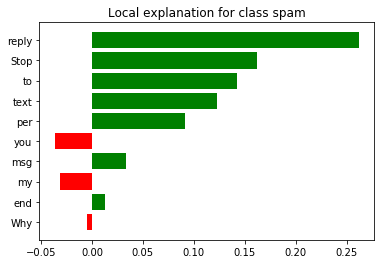

In [233]:
%matplotlib inline
# The explanations can be returned as a matplotlib barplot
fig = exp.as_pyplot_figure()

In [234]:
exp.show_in_notebook(text=False)

In [235]:
# A visualization of the original document, with the words in the explanations highlighted. Notice how the words that affect the classifier the most are all in the email header.
exp.show_in_notebook(text=True)

Since LIME is model-agnoistic, this explainer works for any classifier with the predict_proba function.

## Part 5: Logistic Regression and SHAP for Explanation

We will use [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Install SHAP  https://shap.readthedocs.io/en/latest/

> pip install shap which requires tqdm version >= 4.29.1 (pip install tqdm==4.29.1)


In [236]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [237]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 36.7 ms, sys: 7.2 ms, total: 43.9 ms
Wall time: 63.1 ms


Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [238]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [239]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01269556, 0.00347183, 0.00616517, ..., 0.03354907, 0.99725053,
       0.00157706])

In [240]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9877961234745154

In [241]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9936817612314301

#### Explain linear regression model using SHAP

1. Explain the prediction of an instance x by computing the contribution of each feature to the prediction

2. SHAP compute Shapley values to quantify the contribution

3. Therefore, each feature value in each instance has a Shapley values.

4. How to understand the Shapley values?  It can be thought as ``forces`` that either increases or decreases the prediction

In [242]:
import shap #pip install shap which requires tqdm version >= 4.29.1 (pip install tqdm==4.29.1)
shap.initjs()

In [243]:
explainer = shap.LinearExplainer(logreg, X_train_dtm, feature_perturbation="interventional")

In [244]:
print(type(X_test_dtm))

<class 'scipy.sparse.csr.csr_matrix'>


In [245]:
shap_values = explainer.shap_values(X_test_dtm)
X_test_array = X_test_dtm.toarray() # we need to pass a dense version for the plotting functions

#### Explain one "spam" sample's prediction 

1. The baseline for Shapley values is the average of all predictions. 
2. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. 
3. These forces balance each other out at the actual prediction of the data instance.

In [196]:
ind = 16
print(y_test.iloc[ind])
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vect.get_feature_names()
)

1


#### Explain one "non-spam" sample's prediction 

In [197]:
ind = 10
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vect.get_feature_names()
)

##### Summary Plot
Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

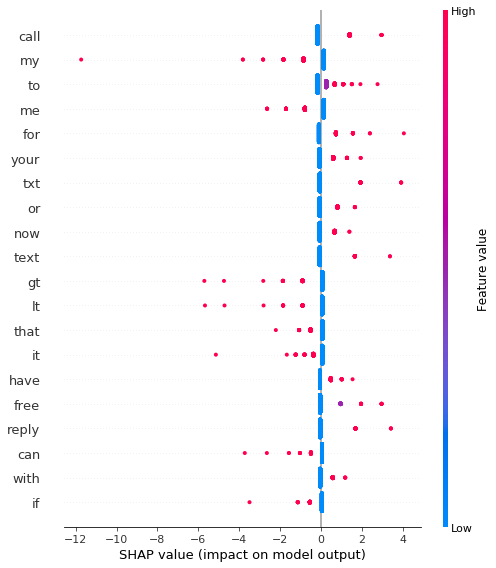

In [198]:
shap.summary_plot(shap_values, X_test_array, feature_names=vect.get_feature_names())

We can also take the mean absolute value of the SHAP values for each feature to get a standard bar plot 

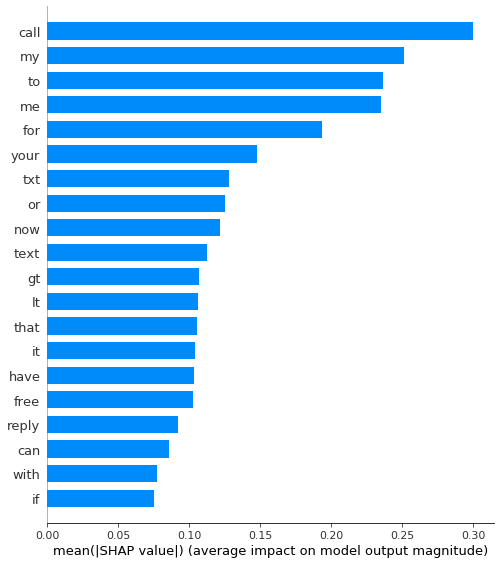

In [199]:
shap.summary_plot(shap_values, X_test_array, feature_names=vect.get_feature_names(), sort=True, plot_type="bar")
# the word "call" is the most important features, changing the predicted spam probability on average by 0.28